# Introduction
There have been an increasing number of wildfires in the United States in the past few years. In particular, California has experienced devastating wildfires such as the [Mendocino Complex Fire](https://www.nytimes.com/2018/08/07/us/california-fires-mendocino.html), the [Carr Fire](https://www.washingtonpost.com/news/post-nation/wp/2018/07/29/grandma-did-everything-she-could-carr-fire-claims-3-more-victims-spreads-in-every-direction/?utm_term=.9a8208a9405a), and the [October 2017 Northern Calfornia wildfires](https://www.nytimes.com/2017/10/10/us/california-fires.html). Experts fear that the wildfires may have become a recurring threat in the state owing to factors such as [climate change](https://www.nytimes.com/2017/12/07/climate/california-fires-warming.html).

We are interested in studying wildfires over the past few decades to see if there is an upward trend in these disasters, and to explore ways to curtail the rise in wildfires. We wish to examine wildfires in specific states and also the entire United States.

We will be studying the [Fire Program Analysis (FPA) fire-occurrence database](https://www.fs.usda.gov/rds/archive/Product/RDS-2013-0009.4/), a database of wildfires reported by federal, state, and local organizations over 24 years, from 1992 to 2014. This database further prepared on and downloaded from [Kaggle](https://www.kaggle.com/rtatman/188-million-us-wildfires) contains records of 1.88 million fires. 

# Querying and Examining the Database

Let us begin by examining the tables contained in the FPA database. We will be using SQLite interfaced with Python, requiring the use of functions contained in sqlite_helpers.py which allow us to run SQL commands and queries through Python.

In [1]:
import pandas as pd
import sqlite_helpers

database = 'FPA_FOD_20170508.sqlite'

# Return list of tables and views in the database
sqlite_helpers.show_tables(database)

,name,type
0,spatial_ref_sys,table
1,spatialite_history,table
2,sqlite_sequence,table
3,geometry_columns,table
4,geom_cols_ref_sys,view
5,spatial_ref_sys_aux,table
6,spatial_ref_sys_all,view
7,views_geometry_columns,table
8,virts_geometry_columns,table
9,geometry_columns_statistics,table


We will be primarily working with the Fires table in this database, as this table contains wildfire data from 1992 to 2015.

In [2]:
sqlite_helpers.run_query(database, '''SELECT * FROM Fires LIMIT 1''')

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...


# Overview of Wildfire Devastation

We have introduced this project by mentioning how wildfires are on the rise, and may continue getting worse in the future. Let us look at the number of acres burned by wildfires every year from 1992 to 2015 to assess whether or not such a positive trend exists.

(1991.9, 2015.25)

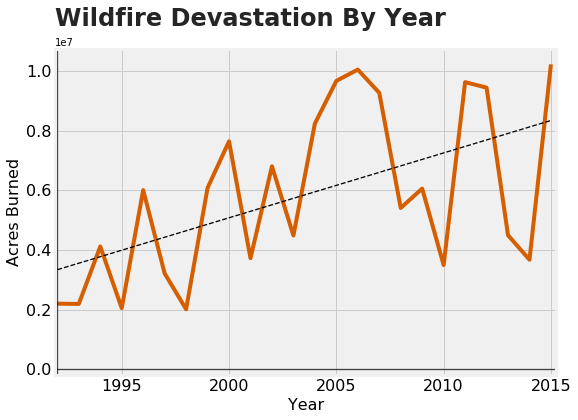

In [3]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LinearRegression
style.use('fivethirtyeight')
%matplotlib inline

fires_by_year_query = '''
SELECT FIRE_YEAR year, SUM(FIRE_SIZE) acres_burned
FROM Fires
GROUP BY FIRE_YEAR
ORDER BY FIRE_YEAR
'''

fires_by_year = sqlite_helpers.run_query(database, fires_by_year_query)

# Fit line to acres burned vs. year data with linear regression
lr = LinearRegression()
lr.fit(fires_by_year[['year']], fires_by_year['acres_burned'])
size_linear = lr.predict(fires_by_year[['year']])

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
fires_by_year.plot(x = 'year', y = 'acres_burned', ax = ax, fontsize = 16, c = [213/255,94/255,0])
ax.plot(fires_by_year['year'], size_linear, lw = 1.3, ls = 'dashed', color = 'black')
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Acres Burned', fontsize = 16)

ax.axvline(fires_by_year['year'].min(), color = 'black', lw = 1.3, alpha = .7)
ax.axhline(0, color = 'black', lw = 1.3, alpha = .7)

ax.text(fires_by_year['year'].min() - .1, 1.15e7, 'Wildfire Devastation By Year', 
        fontsize = 24, alpha = .85, weight = 'bold')

ax.legend_.remove()
ax.set_ylim(ymin = -2e5)
ax.set_xlim([fires_by_year['year'].min() - .1, fires_by_year['year'].max() + .25])

As confirmed by a rough application of linear regression, there has been a rise in acres burned by wildfires per year, from 2,000,000 acres in 1992 to roughly 10,000,000 acres in 2015. It would be a huge oversimplification if we say the relationship between the total size of fires in the United States and the year was strictly linear, considering we see many local maxima and minima. What is interesting is that there is are noticeable peaks in total acres burned in 2006 and 2015, although the jump from 2014 to 2015 is far greater than the jump from 2005 to 2006.

# Studying States Most Affected by Fires

We had emphasized wildfires in California in the introduction. However, is it fair to focus only on California, or should we look at other states that may have been more devastated by wildfires? Let us look at the states that have had the most acres burned from wildfires from 1992 to 2015, as the size of wildfires is related to how "devastating" they are. 

Text(0.5,0,'Percent')

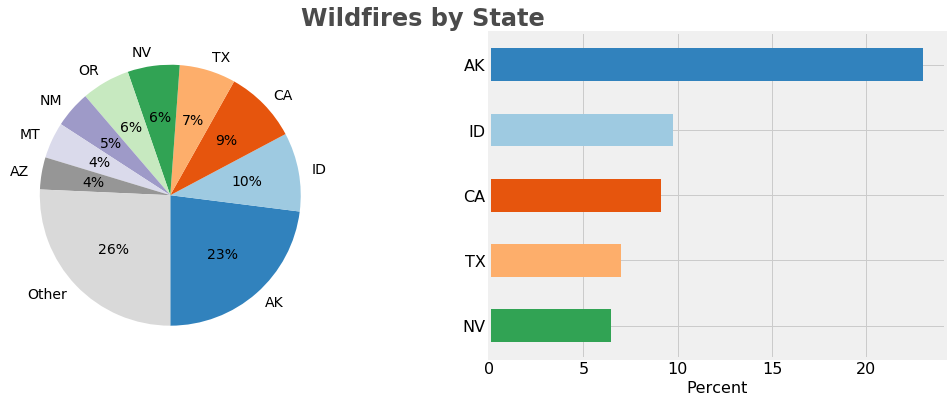

In [4]:
import numpy as np
from matplotlib import cm

# Sum the number of acres burned by wildfires in each state.
# Explicitly list states that have had over 5,000,000 acres burned.
# States that have had fewer than 70,000 are lumped into the "Other" category.
number_of_fires = '''
WITH number_fires_by_state AS
    (
    SELECT state_fires.*, 
    CASE
        WHEN acres_burned < 5000000 THEN "Other"
        ELSE state_fires.name
    END AS State
    FROM 
        (
        SELECT STATE name, SUM(FIRE_SIZE) acres_burned
        FROM Fires
        GROUP BY STATE
        ORDER BY acres_burned DESC
        ) state_fires
    )

    
SELECT State, SUM(acres_burned) Acres_Burned FROM 
    (
    SELECT *,
    CASE
        WHEN State = "Other" THEN 1
        ELSE 0
    END AS sort
    FROM number_fires_by_state
    )
GROUP BY State
ORDER BY sort ASC, Acres_Burned DESC
'''

total_fires = sqlite_helpers.run_query(database, number_of_fires)

total_fires_states = total_fires['Acres_Burned']
total_fires_states.index = list(total_fires['State'])

# Color scheme for pie chart
pie_color_map = [plt.cm.tab20c(i) for i in np.linspace(0, 1, len(total_fires_states))]

fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(121, aspect = 1)
ax2 = fig.add_subplot(122)

total_fires_states.plot.pie(colors = pie_color_map, counterclock = True, startangle = -90, 
                            ax = ax1, autopct = '%.0f%%', fontsize = 14, label = '')
ax1.text(1, 1.3, 'Wildfires by State', fontsize = 24, weight = 'bold', alpha = .7)

top_5 = total_fires_states[:5] / total_fires_states.sum() * 100

top_5[::-1].plot.barh(ax = ax2, color = pie_color_map[4::-1], fontsize = 16)
ax2.set_xlabel('Percent', fontsize = 16)

From 1992 to 2015, the state of Alaska has had the greatest amount of land burned by wildfires. The number of acres burned in Alaska in this time period is more than number of acres burned in Idaho and California combined. 

Let us now look at how many acres were burned by wildfires in Alaska, California, and Idaho every year from 1992 to 2015. We wish to see if there are any notable years for wildfires in these states. We wish to see if the wildfires in Alaska, California, or Idaho contributed to the rise in acres of land burnt by fires from 1992 to 2015, particularly in 2006 and 2015.

Text(1992,7.15e+06,'Number of acres burned per year in Alaska, Idaho, \nand California.')

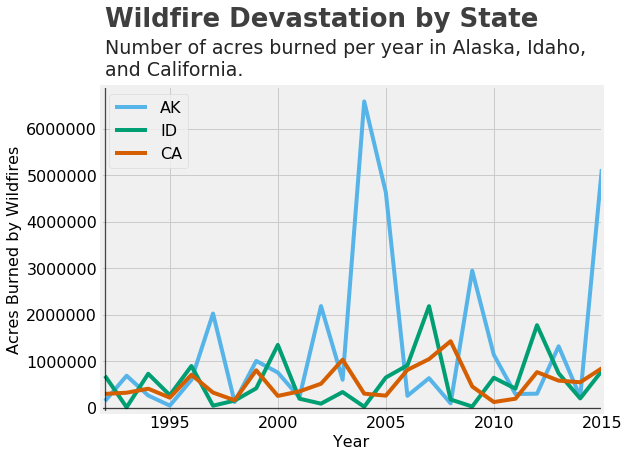

In [5]:
query = '''
WITH
    ak AS
        (
        SELECT FIRE_YEAR Year, SUM(FIRE_SIZE) AK
        FROM Fires
        WHERE STATE = 'AK'
        GROUP BY Year
        ),
    ca AS 
        (
        SELECT FIRE_YEAR Year, SUM(FIRE_SIZE) CA
        FROM Fires
        WHERE STATE = 'CA'
        GROUP BY Year
        ),
    id AS
        (
        SELECT FIRE_YEAR Year, SUM(FIRE_SIZE) ID
        FROM Fires
        WHERE STATE = 'ID'
        GROUP BY Year
        )
    
SELECT ak.Year, ak.AK AK, ca_id.CA CA, ca_id.ID ID
FROM ak
INNER JOIN 
(
    SELECT ca.Year, ca.CA CA, id.ID ID
    FROM ca
    INNER JOIN id ON id.Year = ca.Year
) ca_id ON ca_id.Year = ak.Year
'''
    
# Colorblind-friendly colors
colors = [[230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], 
          [213/255,94/255,0], [0,114/255,178/255]]
    
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
annual_acres_burned = sqlite_helpers.run_query(database, query)
annual_acres_burned.plot(x = 'Year', y = ['AK', 'ID', 'CA'], 
                         fontsize = 16, ax = ax, color = colors[1:])
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Acres Burned by Wildfires', fontsize = 16)
ax.set_xlim([1991.8, 2015])
ax.set_ylim(ymin = -100000)
ax.legend(fontsize = 16, loc = 2)
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
ax.axvline(x = 1992, color = 'black', linewidth = 1.3, alpha = .7)
    
ax.text(1992, 8200000, "Wildfire Devastation by State", fontsize = 26, weight = 'bold', alpha = .75)
ax.text(1992, 7150000, "Number of acres burned per year in Alaska, Idaho, \nand California.", fontsize = 19, alpha = .85)

In general, Alaska has had more wildfires per year than Idaho and California. We do not see spikes in the number of acres burned in 2006, but we do see one in 2004, when over 6,000,000 acres were burned in Alaska, and another peak in 2015, when over 5,000,000 acres were burned. Let us first look at 2015.

Before we move on, we need to realize that the wildfires in the database are classified according to final fire size, as defined by the [National Wildfire Coordinating Group (NWCG)](https://www.nwcg.gov/term/glossary/size-class-of-fire%C2%A0):
- Class A: 0-0.25 acre
- Class B: 0.26-9.9 acres
- Class C: 10.0-99.9 acres
- Class D: 100-299 acres
- Class E: 300-999 acres
- Class F: 1000-4999 acres
- Class G: 5000+ acres

The most devastating wildfires have had sizes well over 5000 acres, and are classified under Class G. For example, the Mendocino Complex Fire [burned 459,123 acres](https://inciweb.nwcg.gov/incident/6073/). It is likely that a majority of the acres burned were burned by Class G wildfires, so when we need to, we will focus on this class of fires.

## Alaska

In [6]:
query = '''
SELECT * FROM Fires
WHERE STATE = 'AK' AND FIRE_YEAR = 2015 AND FIRE_SIZE_CLASS = 'G'
ORDER BY FIRE_SIZE DESC
'''

pd.set_option('display.max_columns', 100)

alaska_2015 = sqlite_helpers.run_query(database, query)
alaska_2015

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1804784,300218278,FWS-2015USAKNORJTP1,FED,FWS-FMIS,FWS,USAKNOR,Nowitna National Wildlife Refuge,USAKNOR,NOWITNA NWR,None,None,JTP1,15533 BIG CREEK 2,2808952,Big Creek Two,AK6457315474120150703,MIDDLE YUKON FIRES,MIDDLE YUKON FIRES COMPLEX,2015,2457195.5,173,1700,1.0,Lightning,2457294.5,272.0,1415,312918.3,G,64.734333,-155.009000,4.0,FWS,AK,Yukon-Koyukuk,290,Yukon-Koyukuk,b'\x00\x01\xad\x10\x00\x00>5^\xbaI`c\xc0L\xf7\...
1,1804904,300218404,FWS-2015USAKKURJTH3,FED,FWS-FMIS,FWS,USAKKUR,Koyukuk National Wildlife Refuge,USAKKUR,KOYUKUK NWR,None,None,JTH3,15449 SUSHGITIT HILLS,2794179,Sushgitit Hills,AK6603215302220150621,SUSHGITIT HILLS,None,2015,2457194.5,172,1115,1.0,Lightning,2457294.5,272.0,1415,276038.1,G,65.801162,-153.470071,1.0,BLM,AK,Yukon-Koyukuk,290,Yukon-Koyukuk,b'\x00\x01\xad\x10\x00\x00\xd1\x87\x91\xd2\n/c...
2,1804666,300218151,FWS-2015USAKKURJT05,FED,FWS-FMIS,FWS,USAKKUR,Koyukuk National Wildlife Refuge,USAKKUR,KOYUKUK NWR,None,None,JT05,15539 HOLTNAKATNA,2736460,Holtnakatna,AK6518415621520150623,HOLTNAKATNA,None,2015,2457195.5,173,1615,1.0,Lightning,2457275.5,253.0,1400,213254.1,G,65.184333,-156.214833,4.0,FWS,AK,Yukon-Koyukuk,290,Yukon-Koyukuk,b'\x00\x01\xad\x10\x00\x00\xef\xb2\x15\xea\xdf...
3,1796524,300208149,W-682942,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,JTP9,ISAHULTILA,2813885,Isahultila,AK6586915468120150622,ISAHULTILA,None,2015,2457194.5,172,1816,1.0,Lightning,2457293.5,271.0,1500,149359.3,G,65.869400,-154.681100,9.0,TRIBAL,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00\xc6):\x92\xcbUc\xc0...
4,1796390,300207939,W-682972,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,JS7U,ROCK,2718664,Rock,AK6598315436620150619,ROCK,None,2015,2457192.5,170,1458,1.0,Lightning,2457295.5,273.0,1200,142650.4,G,66.000300,-153.999700,9.0,TRIBAL,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00\xf4\xb9\xda\x8a\xfd...
5,1804647,300218129,FWS-2015USAKINRJS8X,FED,FWS-FMIS,FWS,USAKINR,Innoko National Wildlife Refuge,USAKINR,INNOKO NWR,None,None,JS8X,15362 BLAZO,2715373,Blazo,AK6341815761120150620,BLAZO,None,2015,2457192.5,170,1945,1.0,Lightning,2457293.5,271.0,1500,121339.2,G,63.418333,-157.611167,4.0,FWS,AK,Yukon-Koyukuk,290,Yukon-Koyukuk,b'\x00\x01\xad\x10\x00\x00\xef\x9cw\xad\x8e\xb...
6,1804900,300218400,FWS-2015USAKNORJTQ7,FED,FWS-FMIS,FWS,USAKNOR,Nowitna National Wildlife Refuge,USAKNOR,NOWITNA NWR,None,None,JTQ7,15481 BERING CREEK,2814175,Bering Creek,AK6498315355020150622,BERING CREEK,TANANA AREA FIRES COMPLEX,2015,2457194.5,172,1645,1.0,Lightning,2457294.5,272.0,1415,112806.8,G,64.983333,-153.550000,4.0,FWS,AK,Yukon-Koyukuk,290,Yukon-Koyukuk,b'\x00\x01\xad\x10\x00\x00\x99\x99\x99\x99\x99...
7,1796393,300207944,W-682970,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,JS82,SEA,2719450,Sea,AK6410015373320150620,SEA,None,2015,2457192.5,170,1742,1.0,Lightning,2457294.5,272.0,1415,111193.8,G,64.100000,-153.733300,1.0,BLM,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00\x03\xc5\x8f1w7c\xc0...
8,1804681,300218167,FWS-2015USAKNORJTP5,FED,FWS-FMIS,FWS,USAKNOR,Nowitna National Wildlife Refuge,USAKNOR,NOWITNA NWR,None,None,JTP5,15469 BIG MUD RIVER 1,2716794,Big Mud River 1,AK6467415292620150622,BIG MUD RIVER 1,None,2015,2457194.5,172,1815,1.0,Lightning,2457294.5,272.0,1415,103967.5,G,64.673667,-152.925833,4.0,FWS,AK,Yukon-Koyukuk,290,Yukon-Koyukuk,b'\x00\x01\xad\x10\x00\x00k\xd1]m\xa0\x1dc\xc0...
9,1796595,300208245,

The largest individual wildfire in 2015, the Middle Yukon Fires (15533 Big Creek 2), burned 312,918 acres and was caused by lightning. We notice that it is part of the Middle Yukon Fires Complex, a group of fires in the same general area. We also notice that a few other fires are part of a separate fire complex, the Tanana Area Fires Complex. Let us look at the most devastating fire complexes in Alaska in 2015.

In [7]:
query = '''
SELECT COMPLEX_NAME, SUM(FIRE_SIZE) Acre_Burned FROM Fires
WHERE STATE = 'AK' AND FIRE_YEAR = 2015 AND FIRE_SIZE_CLASS = 'G'
GROUP BY COMPLEX_NAME
ORDER BY Acre_Burned DESC
'''

sqlite_helpers.run_query(database, query)

,COMPLEX_NAME,Acre_Burned
0,None,3664911.09
1,TANANA AREA FIRES COMPLEX,506048.20
2,MIDDLE YUKON FIRES COMPLEX,487811.60
3,ANIAK COMPLEX,253411.50
4,REX COMPLEX,16106.00


The largest fire complex in Alaska in 2015 was the Tanana Area Fires Complex, followed by the Middle Yukon Fires Complex. The two fire complexes, together, burned close to 1,000,000 acres. Let us examine the fires in these two fire complexes with more detail.

In [8]:
query = '''
SELECT
    FIRE_NAME,
    ICS_209_NAME,
    MTBS_FIRE_NAME,
    COMPLEX_NAME,
    FIRE_YEAR,
    DISCOVERY_DATE,
    STAT_CAUSE_DESCR,
    CONT_DATE,
    FIRE_SIZE,
    FIRE_SIZE_CLASS,
    LATITUDE,
    LONGITUDE,
    STATE,
    COUNTY
FROM Fires
WHERE COMPLEX_NAME = 'TANANA AREA FIRES COMPLEX'
    OR COMPLEX_NAME = 'MIDDLE YUKON FIRES COMPLEX'
ORDER BY COMPLEX_NAME
'''

complex_fires_2015 = sqlite_helpers.run_query(database, query)

# The dates in the tables in the database are written in Julian time
# Reference time is January 1, 4713 BC on the Julian calendar
# Convert to similar YYYY/MM/DD format
epoch = pd.to_datetime(0, unit='s').to_julian_date()    # Reference for Julian time
complex_fires_2015['DISCOVERY_DATE'] =  pd.to_datetime(complex_fires_2015['DISCOVERY_DATE'] - epoch, unit='D')
complex_fires_2015['CONT_DATE'] =  pd.to_datetime(complex_fires_2015['CONT_DATE'] - epoch, unit='D')

complex_fires_2015

,FIRE_NAME,ICS_209_NAME,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY
0,TRAIL CREEK,Trail Creek,MIDDLE YUKON FIRES,MIDDLE YUKON FIRES COMPLEX,2015,2015-06-23,Lightning,2015-08-01,29501.4,G,64.366700,-155.100000,AK,None
1,RUBY SLOUGH,None,None,MIDDLE YUKON FIRES COMPLEX,2015,2015-06-20,Lightning,2015-09-07,49.0,C,64.675800,-155.666330,AK,None
2,NULATO,Nulato,NULATO,MIDDLE YUKON FIRES COMPLEX,2015,2015-06-21,Lightning,2015-09-28,42402.8,G,64.729700,-158.152500,AK,None
3,BRUNO CREEK,Bruno Creek,BRUNO CREEK,MIDDLE YUKON FIRES COMPLEX,2015,2015-06-21,Lightning,2015-09-29,15131.7,G,64.580800,-155.336900,AK,None
4,15598 FLINT CREEK,Flint Creek,MIDDLE YUKON FIRES,MIDDLE YUKON FIRES COMPLEX,2015,2015-06-23,Lightning,2015-07-10,35748.9,G,64.533333,-154.733333,AK,Yukon-Koyukuk
5,15533 BIG CREEK 2,Big Creek Two,MIDDLE YUKON FIRES,MIDDLE YUKON FIRES COMPLEX,2015,2015-06-22,Lightning,2015-09-29,312918.3,G,64.734333,-155.009000,AK,Yukon-Koyukuk
6,15601 LOST RIVER,Middle Yukon,MIDDLE YUKON FIRES,MIDDLE YUKON FIRES COMPLEX,2015,2015-06-23,Lightning,2015-07-10,52108.5,G,64.366100,-154.758600,AK,Yukon-Koyukuk
7,SPICER CREEK,Spicer Creek,TANANA AREA FIRES,TANANA AREA FIRES COMPLEX,2015,2015-06-19,Lightning,2015-10-07,98247.1,G,65.328830,-151.689500,AK,None
8,MOOSE POINT,Moose Point,MOOSE POINT,TANANA AREA FIRES COMPLEX,2015,2015-06-20,Lightning,2015-09-06,13775.5,G,64.980800,-154.267800,AK,None
9,BLIND RIVER,Blind River,BLIND RIVER,TANANA AREA FIRES COMPLEX,2015,2015-06-22,Lightning,2015-07-11,60806.6,G,65.130420,-152.967140,AK,None


The fires in each fire complex were discovered in the month of June. While the fires in the Middle Yukon Fires Complex were contained by September at the latest, the fires in the Tanana Area Fires Complex were contained by October at the latest. All of the fires in these two complexes were caused by lightning. Interestingly, only one of the fires, the Kokrine Fire in the Tanana Area Fires Complex, was a Class F wildfire (1000-4999 acres) that was contained 2-3 months after it was discovred.

The spike in acres burned in Alaska in 2015 has been linked to [warmer temperatures, resulting in drier conditions](https://www.washingtonpost.com/news/energy-environment/wp/2015/07/26/alaskas-terrifying-wildfire-season-and-what-it-says-about-climate-change/?noredirect=on&utm_term=.455752fdb014).

While this will not give us information about what happened in 2006, we can continue investigating Alaska's history of wildfires, particularly the peak in acres burned in 2004.

In [9]:
query = '''
SELECT * FROM Fires
WHERE STATE = 'AK' AND FIRE_YEAR = 2004 AND FIRE_SIZE_CLASS = 'G'
ORDER BY FIRE_SIZE DESC
'''

sqlite_helpers.run_query(database, query)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,305586,311398,W-125452,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A4SZ,BOUNDARY,AK-FAS-73411193,Boundary Fire,AK6526314694320040613,BOUNDARY,None,2004,2453169.5,165,1345,1.0,Lightning,2453278.5,274.0,1630,537627.0000,G,65.26630,-146.8858,7.0,STATE,AK,None,None,None,"b""\x00\x01\xad\x10\x00\x00~\xd9=yX\\b\xc04\xbb..."
1,305685,311501,W-124672,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A7AA,DALL CITY,None,None,AK6628114999320040706,DALL CITY,None,2004,2453192.5,188,1800,1.0,Lightning,2453297.5,293.0,1150,483280.0000,G,66.30290,-149.8843,4.0,FWS,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00I{\x83/L\xbcb\xc0\\}...
2,305643,311457,W-125467,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A5RC,BILLY CK,AK-TAS-413889,TAYLOR COMPLEX,AK6377414344020040618,TAYLOR HIGHWAY COMPLEX (BILLY CREEK),TAYLOR COMPLEX,2004,2453174.5,170,1440,1.0,Lightning,2453318.5,314.0,0945,463994.0000,G,63.81630,-143.8190,7.0,STATE,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00\x90\xed|?5\xfaa\xc0...
3,305584,311396,W-125143,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A4RZ,NORTH DAG,None,None,AK6563215247220040612,NORTH DAG,None,2004,2453168.5,164,2316,1.0,Lightning,2453300.5,296.0,0809,419884.0000,G,65.74670,-152.2315,1.0,BLM,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00\xc4 \xb0rh\x07c\xc0...
4,305620,311432,W-124759,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A4XX,PINGO,AK-UYD-000023,Pingo,AK6721914633320040615,PINGO,SOLSTICE COMPLEX,2004,2453171.5,167,1140,1.0,Lightning,2453297.5,293.0,1150,403993.0000,G,67.20710,-146.3702,9.0,TRIBAL,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00U\x9f\xab\xad\xd8Kb\...
5,305622,311434,W-125635,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A4XV,WINTER TRAILL,AK-UYD-000052,Winter Trail,AK6706314516120040615,WINTER TRAIL,SOLSTICE COMPLEX,2004,2453171.5,167,1339,1.0,Lightning,2453297.5,293.0,1150,344833.0000,G,66.95970,-145.3460,4.0,FWS,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00O\x8d\x97n\x12+b\xc0...
6,305627,311439,W-125921,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A46Q,CHICKEN 1,AK-TAS-413244,Chicken Complex,AK6384514248320040615,TAYLOR HIGHWAY COMPLEX (CHICKEN),TAYLOR COMPLEX,2004,2453171.5,167,1540,1.0,Lightning,2453318.5,314.0,0945,320155.0000,G,64.01630,-142.0023,7.0,STATE,AK,None,None,None,"b""\x00\x01\xad\x10\x00\x00\xfc\x18s\xd7\x12\xc..."
7,305650,311464,W-125468,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A5DZ,PORCUPINE,AK-TAS-413293,Porcupine,AK6349714262320040626,TAYLOR HIGHWAY COMPLEX (PORCUPINE),TAYLOR COMPLEX,2004,2453177.5,173,1558,1.0,Lightning,2453318.5,314.0,0945,284595.0000,G,63.44970,-142.6689,7.0,STATE,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00j\t\xf9\xa0g\xd5a\xc...
8,305664,311479,W-124147,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A6AU,BONANZA CK,None,None,AK6457815738420040628,BONANZA CREEK,None,2004,2453184.5,180,0820,1.0,Lightning,2453310.5,306.0,1200,265919.9000,G,64.46770,-157.1933,4.0,FWS,AK,None,None,None,"b'\x00\x01\xad\x10\x00\x00""J{\x83/\xa6c\xc0\xb..."
9,305616,311428,W-124706,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,None,None,A4WG,EDWARDSCR,AK-UYD-000041,Eagle Complex,AK6555414313620040614,EDWARDS CREEK,EAGLE COMP

The largest individual wildfire in 2004 burned 537,627 acres. However, there were several fires that burned over 100,000 acres. In particular, we have noticed that a few of the worst wildfires are categorized under "TAYLOR COMPLEX" for wildfire complexes, or groups of wildfires in the same general area. Let us organize these wildfires based on fire complexes.

In [10]:
query = '''
SELECT COMPLEX_NAME, SUM(FIRE_SIZE) Acre_Burned FROM Fires
WHERE STATE = 'AK' AND FIRE_YEAR = 2004
GROUP BY COMPLEX_NAME
ORDER BY Acre_Burned DESC
'''

sqlite_helpers.run_query(database, query)

,COMPLEX_NAME,Acre_Burned
0,None,2.898467e+06
1,TAYLOR COMPLEX,1.303333e+06
2,SOLSTICE COMPLEX,8.325473e+05
3,CENTRAL COMPLEX,7.895777e+05
4,EAGLE COMPLEX,6.633062e+05
5,YUKON CROSSING COMPLEX,1.046370e+05


The largest wildfire complex in Alaska in 2004 was the Taylor Complex fire, which burned over 1.3 million acres, roughly 500,000 more acres than the Solstice Complex, the second largest wildfire complex, and roughly 800,000 more acres than the Tanana Area Fires Complex. This is, in fact, the largest wildfire complex in the United States from 1992 to 2015.

In [11]:
query = '''
SELECT STATE, FIRE_YEAR, COMPLEX_NAME, SUM(FIRE_SIZE) Acre_Burned FROM Fires
GROUP BY COMPLEX_NAME
ORDER BY Acre_Burned DESC
LIMIT 10
'''

sqlite_helpers.run_query(database, query)

,STATE,FIRE_YEAR,COMPLEX_NAME,Acre_Burned
0,CA,2015,None,1.056634e+08
1,AK,2004,TAYLOR COMPLEX,1.303333e+06
2,TX,2006,EAST AMARILLO COMPLEX,9.072450e+05
3,AK,2004,SOLSTICE COMPLEX,8.325473e+05
4,AK,2004,CENTRAL COMPLEX,7.895777e+05
5,NV,2005,SOUTHERN NEVADA COMPLEX,7.364550e+05
6,AZ,2011,MURPHY COMPLEX,7.230881e+05
7,OR,2015,EAGLE COMPLEX,6.760222e+05
8,AK,2009,RAILBELT COMPLEX,6.311940e+05
9,AK,2015,TANANA AREA FIRES COMPLEX,5.101368e+05


We note that the second largest fire complex after the Taylor Complex is the East Amarillo Complex in Texas in 2006. We will look further into that later. For now, we can make a query to look at the features of the Taylor Complex wildfire that burned 1.3 million acres.

In [12]:
query = '''
SELECT 
    FIRE_NAME,
    ICS_209_NAME,
    MTBS_FIRE_NAME,
    COMPLEX_NAME,
    FIRE_YEAR,
    DISCOVERY_DATE,
    STAT_CAUSE_DESCR,
    CONT_DATE,
    FIRE_SIZE,
    FIRE_SIZE_CLASS,
    LATITUDE,
    LONGITUDE,
    STATE,
    COUNTY
FROM Fires
WHERE COMPLEX_NAME = 'TAYLOR COMPLEX'
ORDER BY FIRE_SIZE
'''

taylor_complex_fires = sqlite_helpers.run_query(database, query)

# Convert Julian times to YYYY/MM/DD
taylor_complex_fires['DISCOVERY_DATE'] =  pd.to_datetime(taylor_complex_fires['DISCOVERY_DATE'] - epoch, unit='D')
taylor_complex_fires['CONT_DATE'] =  pd.to_datetime(taylor_complex_fires['CONT_DATE'] - epoch, unit='D')

taylor_complex_fires

,FIRE_NAME,ICS_209_NAME,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY
0,ANOMALY,Chicken Complex,TAYLOR HIGHWAY COMPLEX (ANOMALY),TAYLOR COMPLEX,2004,2004-06-29,Lightning,2004-07-22,19667.0,G,63.9163,-142.7189,AK,None
1,WALLSTREET,Chicken Complex,TAYLOR HIGHWAY COMPLEX (WALL STREET),TAYLOR COMPLEX,2004,2004-06-22,Lightning,2004-07-19,89279.0,G,64.0663,-141.6856,AK,None
2,GARDINER C,TAYLOR COMPLEX,TAYLOR HIGHWAY COMPLEX (GARDINER CREEK),TAYLOR COMPLEX,2004,2004-06-17,Lightning,2004-11-09,125643.0,G,63.0830,-141.3355,AK,None
3,PORCUPINE,Porcupine,TAYLOR HIGHWAY COMPLEX (PORCUPINE),TAYLOR COMPLEX,2004,2004-06-21,Lightning,2004-11-09,284595.0,G,63.4497,-142.6689,AK,None
4,CHICKEN 1,Chicken Complex,TAYLOR HIGHWAY COMPLEX (CHICKEN),TAYLOR COMPLEX,2004,2004-06-15,Lightning,2004-11-09,320155.0,G,64.0163,-142.0023,AK,None
5,BILLY CK,TAYLOR COMPLEX,TAYLOR HIGHWAY COMPLEX (BILLY CREEK),TAYLOR COMPLEX,2004,2004-06-18,Lightning,2004-11-09,463994.0,G,63.8163,-143.8190,AK,None


What the fires in the Taylor Complex wildfire have in common is that they were all Class G wildfires caused by lightning from mid to late June 2004. Given how common thunderstorms are in the summer in Alaska and given the large areas of forests in Alaska, wildfires caused by lightning are common in Alaska. The high degree of devastation in 2004 was attributed to [the strange weather in Alaska](https://www.adn.com/science/article/hot-and-smoky-summer-2004-left-fairbanks-parched/2015/05/23/): The interior of Alaska was experiencing above average temperatures and a high occurrence of lightning strikes. These were optimal conditions for fires.

We also note that the largest fires in this complex were the ones that were contained in November, roughly five months after they were discovered.

## 2006 and 2015

We want to redirect our attention to 2006 and 2015. Let us see where wildfires were the most devastating in these two years.

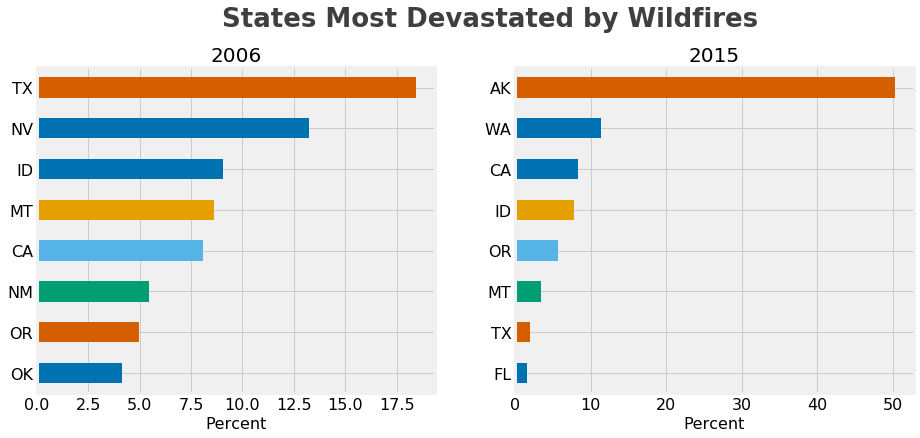

In [13]:
query_2006 = '''
SELECT
    STATE state, 
    SUM(FIRE_SIZE) / (SELECT SUM(FIRE_SIZE) FROM Fires WHERE FIRE_YEAR = 2006) * 100 acres_burned 
FROM Fires
WHERE FIRE_YEAR = 2006
GROUP BY state
ORDER BY acres_burned DESC
LIMIT 8
'''

query_2015 = '''
SELECT
    STATE state, 
    SUM(FIRE_SIZE) / (SELECT SUM(FIRE_SIZE) FROM Fires WHERE FIRE_YEAR = 2015) * 100 acres_burned 
FROM Fires
WHERE FIRE_YEAR = 2015
GROUP BY state
ORDER BY acres_burned DESC
LIMIT 8
'''

fires_2006 = sqlite_helpers.run_query(database, query_2006)
percent_fires_2006 = fires_2006['acres_burned']
percent_fires_2006.index = list(fires_2006['state'])

fires_2015 = sqlite_helpers.run_query(database, query_2015)
percent_fires_2015 = fires_2015['acres_burned']
percent_fires_2015.index = list(fires_2015['state'])

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

percent_fires_2006[::-1].plot.barh(ax = ax1, color = colors[::-1], fontsize = 16)
percent_fires_2015[::-1].plot.barh(ax = ax2, color = colors[::-1], fontsize = 16)
ax1.set_title('2006', fontsize = 20); ax1.set_xlabel('Percent', fontsize = 16)
ax2.set_title('2015', fontsize = 20); ax2.set_xlabel('Percent', fontsize = 16)
ax1.text(9, 8.5, 'States Most Devastated by Wildfires', fontsize = 26, weight = 'bold', alpha = .75);

We previously considered the three states Alaska, California, and Idaho because they had the largest number of acres burned by wildfires from 1992 to 2015. Indeed, the majority of acres burned in 2015 was in Alaska, where two fire complexes burned 1,000,000 acres of land, and standalone fires burned about 3.6 million acres of land. 

We are not surprised that Texas had the largest number of acres burned in 2006, considering the second largest fire complex in the United States from 1992 to 2015 happened in Texas: The East Amarillo Complex, which burned about 900,000 acres of land.

What is curious is the number of acres burned in Texas in 2006 was not the majority of land burned in 2006. Indeed, about half of the acres burned in 2006 were across Texas, Nevada, Idaho, Montana, and California.

Let us look at the top causes of wildfires in the top five states in 2006, and the top three states in 2015. We will only be looking at Class G wildfires, as these have been the most devastating.

In [14]:
query_tx = '''
SELECT STAT_CAUSE_DESCR Texas FROM Fires
WHERE STATE = 'TX' AND FIRE_YEAR = 2006 AND FIRE_SIZE_CLASS = 'G'
GROUP BY Texas
ORDER BY COUNT(*) DESC
LIMIT 3
'''

texas_2006 = sqlite_helpers.run_query(database, query_tx)

query_nv = '''
SELECT STAT_CAUSE_DESCR Nevada FROM Fires
WHERE STATE = 'NV' AND FIRE_YEAR = 2006 AND FIRE_SIZE_CLASS = 'G'
GROUP BY Nevada
ORDER BY COUNT(*) DESC
LIMIT 3
'''

nevada_2006 = sqlite_helpers.run_query(database, query_nv)

query_id = '''
SELECT STAT_CAUSE_DESCR Idaho FROM Fires
WHERE STATE = 'ID' AND FIRE_YEAR = 2006 AND FIRE_SIZE_CLASS = 'G'
GROUP BY Idaho
ORDER BY COUNT(*) DESC
LIMIT 3
'''

idaho_2006 = sqlite_helpers.run_query(database, query_id)

query_mt = '''
SELECT STAT_CAUSE_DESCR Montana FROM Fires
WHERE STATE = 'MT' AND FIRE_YEAR = 2006 AND FIRE_SIZE_CLASS = 'G'
GROUP BY Montana
ORDER BY COUNT(*) DESC
LIMIT 3
'''

montana_2006 = sqlite_helpers.run_query(database, query_mt)

query_ca = '''
SELECT STAT_CAUSE_DESCR California FROM Fires
WHERE STATE = 'CA' AND FIRE_YEAR = 2006 AND FIRE_SIZE_CLASS = 'G'
GROUP BY California
ORDER BY COUNT(*) DESC
LIMIT 3
'''

california_2006 = sqlite_helpers.run_query(database, query_ca)

fires_2006 = pd.concat((texas_2006, nevada_2006, idaho_2006, montana_2006, california_2006), axis = 1)
fires_2006

,Texas,Nevada,Idaho,Montana,California
0,Miscellaneous,Lightning,Lightning,Lightning,Lightning
1,Lightning,Equipment Use,Campfire,Equipment Use,Miscellaneous
2,Equipment Use,Miscellaneous,Equipment Use,Arson,Equipment Use


What Nevada, Idaho, Montana, and Calfiornia have in common is that the top cause of Class G wildfires is lightning. Lightning has caused Class G wildfires in Texas, but there is no one top cause for Class G wildfires in Texas. Interestingly, Class G wildfires have also started from equipment use in all five of these states in 2006. Unlike wildfires caused by lightning, wildfires caused by equipment use are human-caused. Other identified top causes of wildfires in these states include campfires and arson.

Before we move on to 2015, let us look closely at the East Amarillo Complex in Texas, and see what the causes of the fires in this complex were.

In [15]:
query = '''
SELECT
    FIRE_NAME,
    ICS_209_NAME,
    MTBS_FIRE_NAME,
    COMPLEX_NAME,
    FIRE_YEAR,
    DISCOVERY_DATE,
    STAT_CAUSE_DESCR,
    CONT_DATE,
    FIRE_SIZE,
    FIRE_SIZE_CLASS,
    LATITUDE,
    LONGITUDE,
    STATE,
    COUNTY
FROM Fires
WHERE COMPLEX_NAME = 'EAST AMARILLO COMPLEX'
ORDER BY FIRE_SIZE
'''

sqlite_helpers.run_query(database, query)

,FIRE_NAME,ICS_209_NAME,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY
0,I-40,East Amarillo Complex,EAST AMARILLO COMPLEX,EAST AMARILLO COMPLEX,2006,2453806.5,Miscellaneous,2453813.5,427696.0,G,35.216667,-100.933333,TX,179
1,HWY 152,East Amarillo Complex,EAST AMARILLO COMPLEX,EAST AMARILLO COMPLEX,2006,2453806.5,Missing/Undefined,2453806.5,479549.0,G,35.667800,-101.370800,TX,None


What is peculiar is that this deadly fire complex was made up of two wildfires with unspecified causes (there is an article that claims that the fire was caused by power lines, but the veracity of the claim is up to question).

Let us do a similar analysis of the wildfires in 2015.

In [16]:
query_ak = '''
SELECT STAT_CAUSE_DESCR Alaska FROM Fires
WHERE STATE = 'AK' AND FIRE_YEAR = 2015 AND FIRE_SIZE_CLASS = 'G'
GROUP BY Alaska
ORDER BY COUNT(*) DESC
LIMIT 3
'''

alaska_2015 = sqlite_helpers.run_query(database, query_ak)

query_wa = '''
SELECT STAT_CAUSE_DESCR Washington FROM Fires
WHERE STATE = 'WA' AND FIRE_YEAR = 2015 AND FIRE_SIZE_CLASS = 'G'
GROUP BY Washington
ORDER BY COUNT(*) DESC
LIMIT 3
'''

washington_2015 = sqlite_helpers.run_query(database, query_wa)

query_ca = '''
SELECT STAT_CAUSE_DESCR California FROM Fires
WHERE STATE = 'CA' AND FIRE_YEAR = 2015 AND FIRE_SIZE_CLASS = 'G'
GROUP BY California
ORDER BY COUNT(*) DESC
LIMIT 3
'''

california_2015 = sqlite_helpers.run_query(database, query_ca)

fires_2015 = pd.concat((alaska_2015, washington_2015, california_2015), axis = 1)
fires_2015

,Alaska,Washington,California
0,Lightning,Lightning,Lightning
1,Missing/Undefined,Miscellaneous,Equipment Use
2,Miscellaneous,Arson,Missing/Undefined


Lightning is a top cause for Class G wildfires in Alaska (which we have studied in-depth), Washington, and California in 2015. Other causes of Class G wildfires include arson in Washington and equipment use in California, both of which result in human-caused fires.

## Identifying Common Causes of Wildfires

Let us expand this analysis and see what the top causes of wildfires have been from 1992 to 2015 in all states. Although we have been primarily interested in Class G wildfires, we will now be looking at all classes of wildfires.

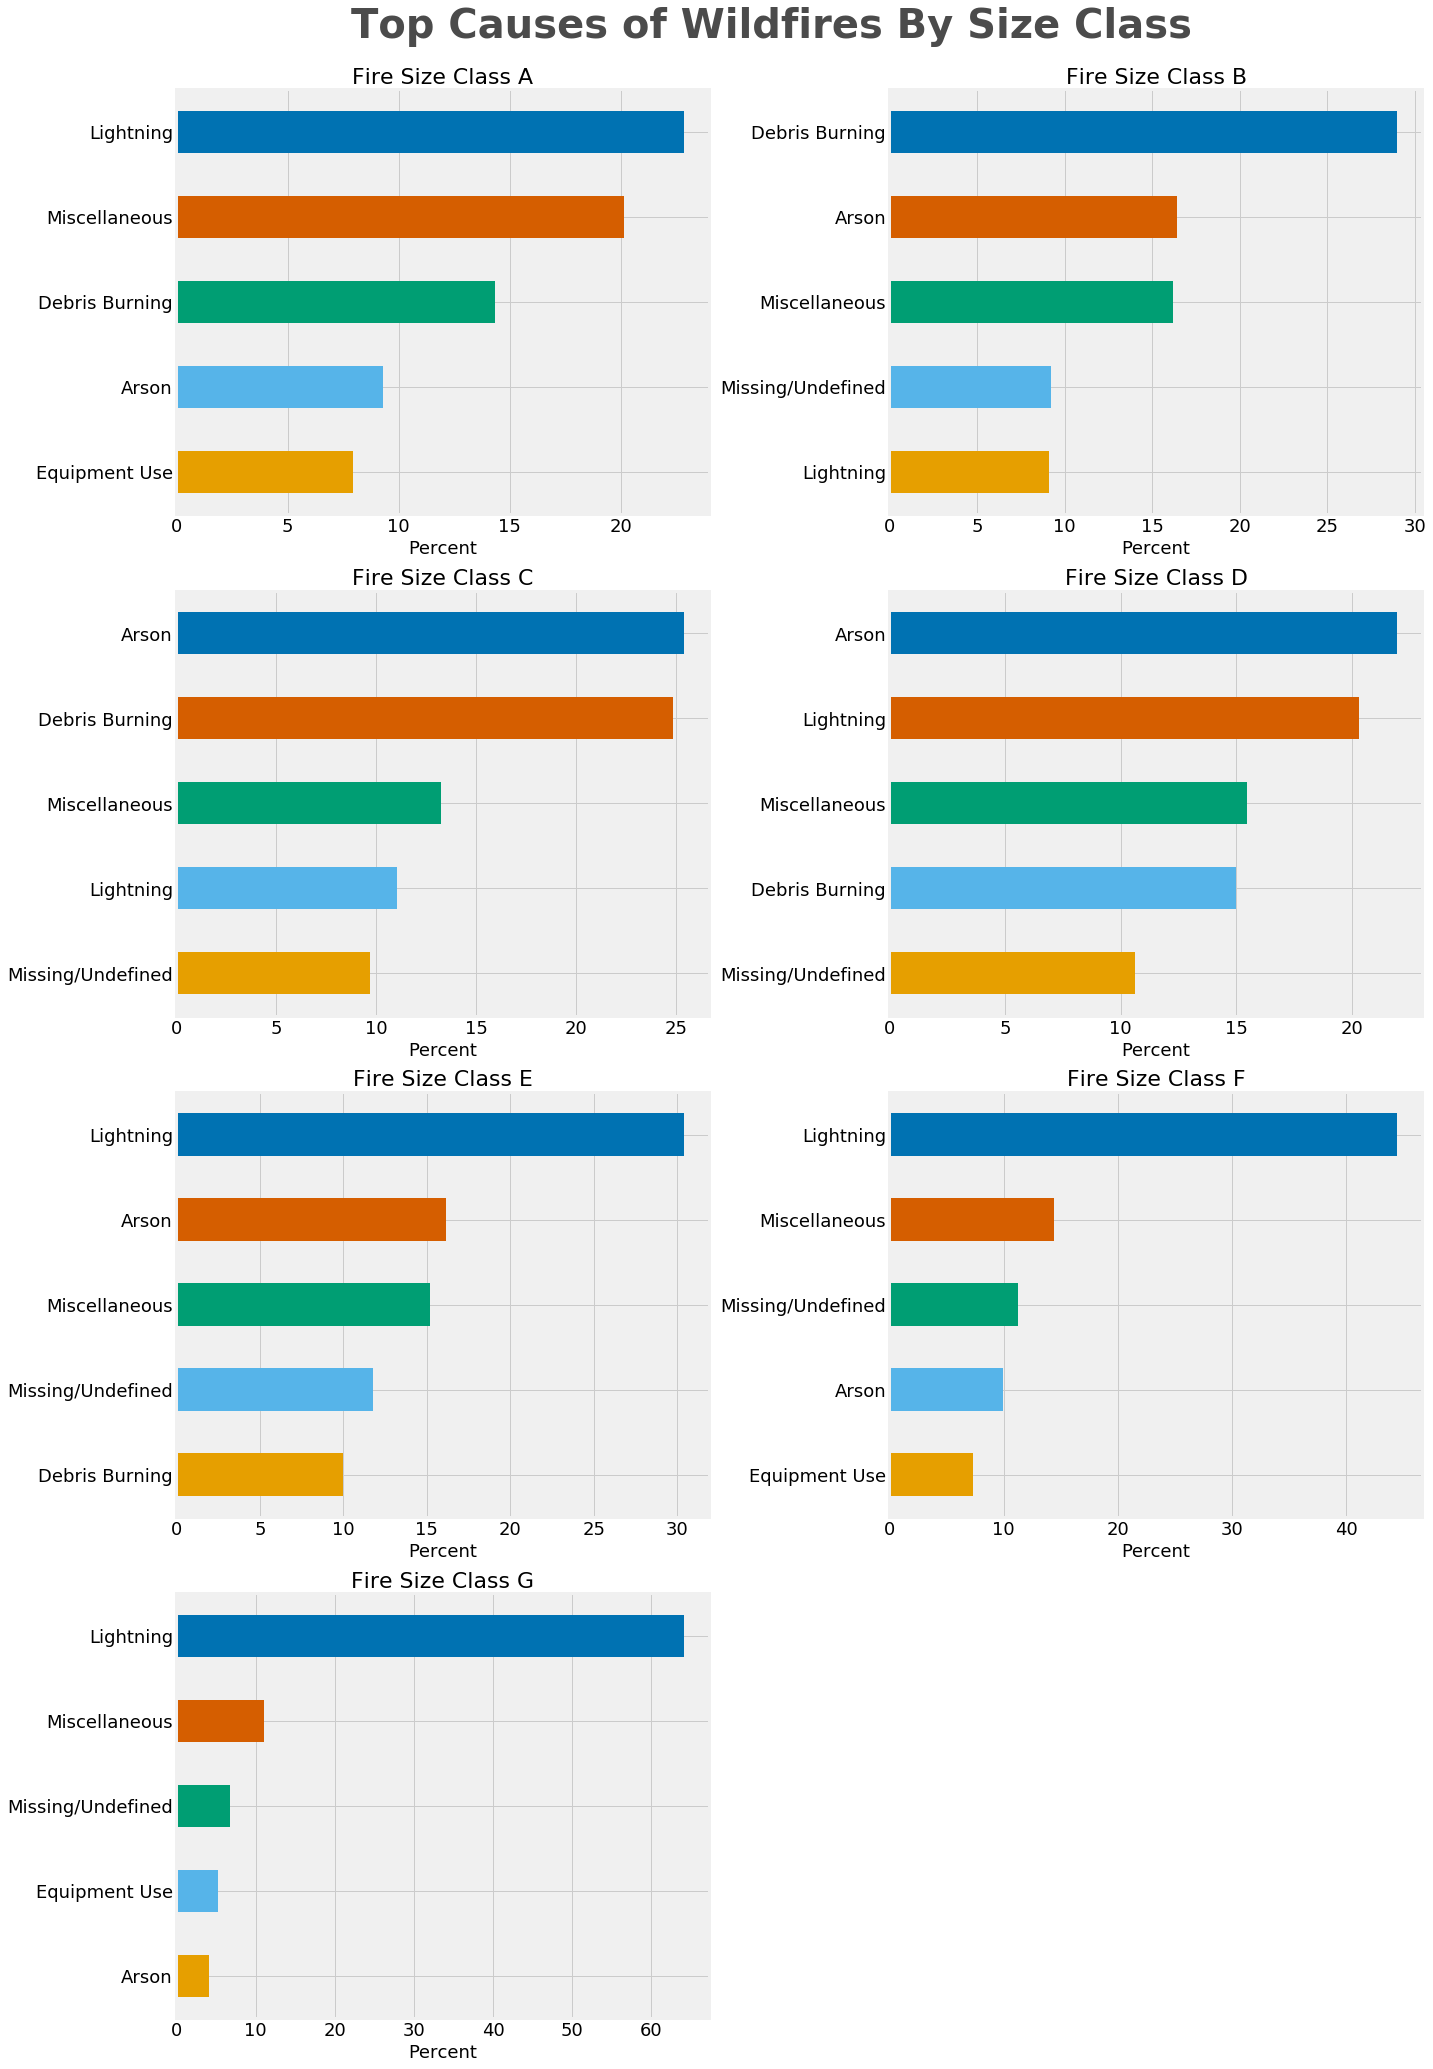

In [17]:
fire_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

fig = plt.figure(figsize = (20, 28))

for i in range(len(fire_classes)):
    query_1 = "SELECT STAT_CAUSE_DESCR cause, CAST(COUNT(*) as FLOAT) / (SELECT COUNT(*) FROM Fires WHERE FIRE_SIZE_CLASS = '"
    query_2 = fire_classes[i]
    query_3 = "') * 100 percent FROM Fires WHERE FIRE_SIZE_CLASS = '"
    query_4 = "' GROUP BY STAT_CAUSE_DESCR ORDER BY percent DESC LIMIT 5"
    query = query_1 + query_2 + query_3 + query_2 + query_4
    
    fires = sqlite_helpers.run_query(database, query)
    percent_fires = fires['percent']
    percent_fires.index = list(fires['cause'])
    
    ax = fig.add_subplot(4, 2, i+1)
    
    percent_fires[::-1].plot.barh(ax = ax, color = colors, fontsize = 18)   
    ax.set_title('Fire Size Class ' + fire_classes[i], fontsize = 22)
    ax.set_xlabel('Percent', fontsize = 18)

ax.text(22, 22.8, 'Top Causes of Wildfires By Size Class', fontsize = 40, weight = 'bold', alpha = .7)
fig.tight_layout()

Lightning is the top cause for Classes A, E, F, and G wildfires. In fact, wildfires caused by lightning make up the majority of Class F and G wildfires. Lightning is still a top cause of wildfires in the other size classes. What is interesting is that for Classes B, C, and D, the top causes are debris burning and arson, both human-caused.

## Wildfires: Nature vs. Human

We are interested in seeing if there are different trends in wildfires caused by lightning (nature) and by humans. If we are intersted in preventing wildfires, we would like to control human-caused wildfires. Let us begin by looking at the states with the most lightning-induced wildfires.

Text(3.7,10.5,'Top States with Lightning-Induced Wildfires')

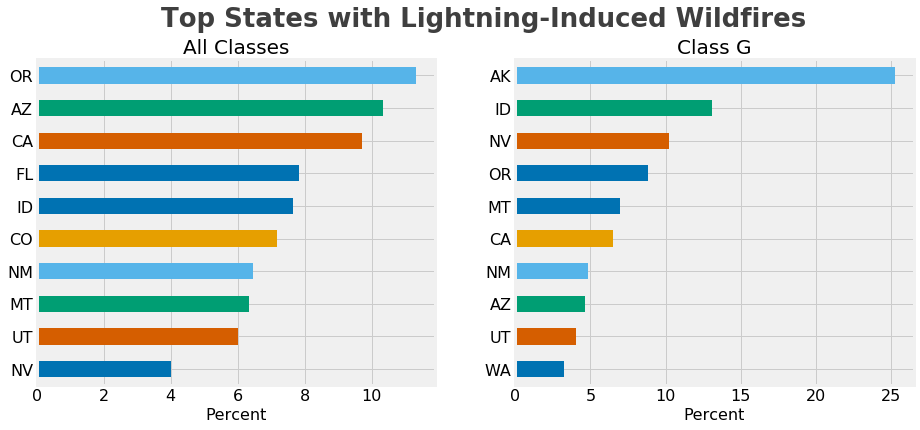

In [18]:
query_1 = '''
SELECT 
    STATE state, 
    CAST(COUNT(*) as FLOAT) / 
    (SELECT COUNT(*) 
    FROM Fires 
    WHERE STAT_CAUSE_DESCR = 'Lightning') * 100 Percent 
FROM Fires
WHERE STAT_CAUSE_DESCR = 'Lightning'
GROUP BY STATE
ORDER BY Percent DESC
LIMIT 10
'''

query_2 = '''
SELECT 
    STATE state, 
    CAST(COUNT(*) as FLOAT) / (
    SELECT COUNT(*) FROM Fires 
    WHERE STAT_CAUSE_DESCR = 'Lightning' 
    AND FIRE_SIZE_CLASS = 'G') * 100 Percent 
FROM Fires
WHERE STAT_CAUSE_DESCR = 'Lightning' AND FIRE_SIZE_CLASS = 'G'
GROUP BY STATE
ORDER BY Percent DESC
LIMIT 10
'''

lightning_all_classes = sqlite_helpers.run_query(database, query_1)
lightning_class_G = sqlite_helpers.run_query(database, query_2)

percent_lightning_all = lightning_all_classes['Percent']
percent_lightning_all.index = list(lightning_all_classes['state'])

percent_lightning_G = lightning_class_G['Percent']
percent_lightning_G.index = list(lightning_class_G['state'])

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

percent_lightning_all[::-1].plot.barh(ax = ax1, color = colors[::-1], fontsize = 16)
percent_lightning_G[::-1].plot.barh(ax = ax2, color = colors[::-1], fontsize = 16)
ax1.set_title('All Classes', fontsize = 20); ax1.set_xlabel('Percent', fontsize = 16)
ax2.set_title('Class G', fontsize = 20); ax2.set_xlabel('Percent', fontsize = 16)
ax1.text(3.7, 10.5, 'Top States with Lightning-Induced Wildfires', fontsize = 26, weight = 'bold', alpha = .75)

This is consistent with our observations regarding how hundreds of thousands, or millions, of acres were burned by wildfires caused by lightning in Alaska. 

Many fires caused by lightning were observed in Arizona, California, and Florida. However, many Class G wildfires caused by lightning were observed in Idaho, Nevada, and Oregon. Indeed, a few of the top states with lightning-caused Class G fires are in the northwest, where there are many forests, like northern California, Idaho, Alaska, Oregon, and Montana. 

A few of the top states with lightning-caused Class G fires are in the southwest. While states like New Mexico, Arizona, and Utah may be known for their deserts, these states also contain ecosystems where forest fires and brush fires can start.

In [19]:
new_mexico_query = '''
SELECT * FROM FIRES
WHERE STATE = 'NM'
    AND FIRE_SIZE_CLASS = 'G'
    AND STAT_CAUSE_DESCR = 'Lightning'
ORDER BY FIRE_SIZE DESC
LIMIT 3
'''

sqlite_helpers.run_query(database, new_mexico_query)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1635008,201750033,ICS209_2009_NM-GNF-000143,INTERAGCY,IA-ICS209,FS,USNMGNF,Gila National Forest,NMGNF,Gila National Forest,None,None,GU3S,WHITEWATER-BALDY,NM-GNF-000143,Whitewater-Baldy,NM3326710859220120509,WHITEWATER-BALDY,WHITEWATER-BALDY COMPLEX,2012,2456063.5,137,1025,1.0,Lightning,2456139.5,213.0,1600,297845.0,G,33.344722,-108.710278,5.0,USFS,NM,Catron,003,Catron,b'\x00\x01\xad\x10\x00\x00\\D\xdb1u-[\xc0 \x1b...
1,1639395,201764013,FS-1518362,FED,FS-FIRESTAT,FS,USNMGNF,Gila National Forest,0306,Gila National Forest,028,8,HJ20,SILVER,NM-GNF-000230,Silver,NM3288810780920130607,SILVER,None,2013,2456450.5,158,1500,1.0,Lightning,NaN,NaN,,234000.0,G,32.888889,-107.809722,5.0,USFS,NM,017,017,Grant,b'\x00\x01\xad\x10\x00\x00\xa4o%}\xd2\xf3Z\xc0...
2,1496448,201168279,2011NM-11-54250987X,NONFED,ST-NASF,ST/C&L,USNMNMS,New Mexico - State Forestry,NMNMS,New Mexico - State Forestry,None,11-54250987X,None,DONALDSON,NM-N5S-000425,DONALDSON,NM3330110523720110628,DONALDSON,None,2011,2455740.5,179,0200,1.0,Lightning,2455757.5,196.0,1800,101562.0,G,33.300667,-105.237056,8.0,PRIVATE,NM,Lincoln,027,Lincoln,b'\x00\x01\xad\x10\x00\x00\x80\xd4\xed\xec+OZ\...


Case in point, the top three devastating wildfires in New Mexico were forest fires (Whitewater-Baldy and Silver) and brush fires (Donaldson).

Let us now look at the human-caused wildfires. First, let us see the causes of wildfires reported in the database.

In [375]:
query = '''
SELECT STAT_CAUSE_DESCR cause FROM Fires
'''

causes = sqlite_helpers.run_query(database, query)
causes['cause'].unique()

array(['Miscellaneous', 'Lightning', 'Debris Burning', 'Campfire',
       'Equipment Use', 'Arson', 'Children', 'Railroad', 'Smoking',
       'Powerline', 'Structure', 'Fireworks', 'Missing/Undefined'],
      dtype=object)

We will exclude fires where the causes are reported as "Lightning", "Miscellaneous", and "Missing/Undefined". All the other causes are more well-defined and connected with human activity.

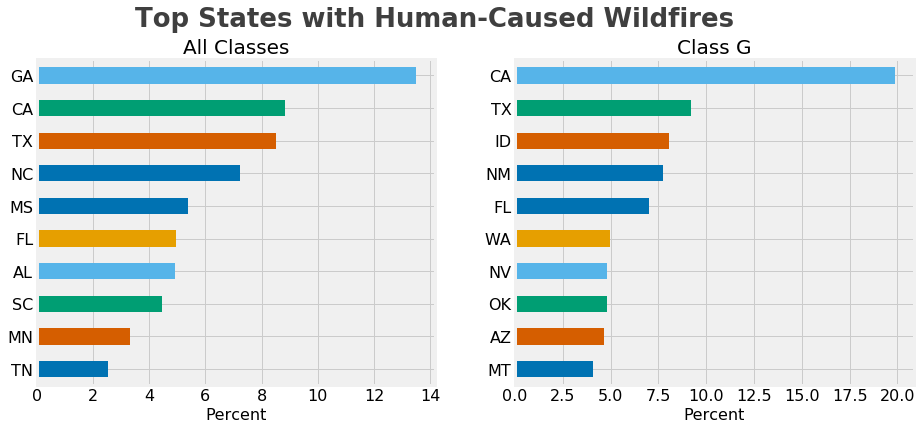

In [23]:
query_1 = '''
SELECT 
    STATE state, 
    CAST(COUNT(*) as FLOAT) / (
        SELECT COUNT(*) FROM Fires 
        WHERE NOT (
            STAT_CAUSE_DESCR = 'Lightning' 
            OR STAT_CAUSE_DESCR = 'Miscellaneous' 
            OR STAT_CAUSE_DESCR = 'Missing/Undefined')
    ) * 100 Percent 
FROM Fires
WHERE NOT (
    STAT_CAUSE_DESCR = 'Lightning' 
    OR STAT_CAUSE_DESCR = 'Miscellaneous' 
    OR STAT_CAUSE_DESCR = 'Missing/Undefined')
GROUP BY STATE
ORDER BY Percent DESC
LIMIT 10
'''

query_2 = '''
SELECT 
    STATE state, 
    CAST(COUNT(*) as FLOAT) / (
        SELECT COUNT(*) total FROM Fires 
        WHERE NOT (
            STAT_CAUSE_DESCR = 'Lightning' 
            OR STAT_CAUSE_DESCR = 'Miscellaneous' 
            OR STAT_CAUSE_DESCR = 'Missing/Undefined')
            AND FIRE_SIZE_CLASS = 'G'
    ) * 100 Percent 
FROM Fires
WHERE NOT (
    STAT_CAUSE_DESCR = 'Lightning' 
    OR STAT_CAUSE_DESCR = 'Miscellaneous' 
    OR STAT_CAUSE_DESCR = 'Missing/Undefined')
    AND FIRE_SIZE_CLASS = 'G'
GROUP BY STATE
ORDER BY Percent DESC
LIMIT 10
'''

manmade_all_classes = sqlite_helpers.run_query(database, query_1)
manmade_class_G = sqlite_helpers.run_query(database, query_2)

percent_manmade_all = manmade_all_classes['Percent']
percent_manmade_all.index = list(manmade_all_classes['state'])

percent_manmade_G = manmade_class_G['Percent']
percent_manmade_G.index = list(manmade_class_G['state'])

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

percent_manmade_all[::-1].plot.barh(ax = ax1, color = colors[::-1], fontsize = 16)
percent_manmade_G[::-1].plot.barh(ax = ax2, color = colors[::-1], fontsize = 16)
ax1.set_title('All Classes', fontsize = 20); ax1.set_xlabel('Percent', fontsize = 16)
ax2.set_title('Class G', fontsize = 20); ax2.set_xlabel('Percent', fontsize = 16)
ax1.text(3.5, 10.5, 'Top States with Human-Caused Wildfires', fontsize = 26, weight = 'bold', alpha = .75);

The top ten states with human-caused wildfires from 1992 to 2015 were Georgia, California, Texas, the Carolinas, Mississippi, Florida, Alabama, Minnesota, and Tennessee. However, the top ten states with human-caused Class G wildfires were California, Texas, Idaho, New Mexico, Florida, Washington, Nevada, Oklahoma, Arizona, and Montana. 

###  California

It will be of interest to Californians to increase fire prevention efforts, as the state has been afflicted with devastating human-caused wildfires up to this year. The Carr Fire from 2018, for instance, was caused by [a spark from a vehicle](https://www.newsweek.com/flat-tire-caused-california-deadly-carr-wildfire-thousands-acres-burned-1057256), and resulted in over [1000 destroyed buildings,](http://cdfdata.fire.ca.gov/incidents/incidents_details_info?incident_id=2164) [deaths,](https://www.nytimes.com/2018/07/28/us/carr-fire-great-grandmother-children-dead.html) and 11 injuries. Let us see which months have had the most acres burned by human-caused Class G wildfires in California.

In [51]:
query = '''
SELECT DISCOVERY_DATE discovery_date, FIRE_SIZE acres_burned FROM Fires
WHERE NOT (
    STAT_CAUSE_DESCR = 'Lightning' 
    OR STAT_CAUSE_DESCR = 'Miscellaneous' 
    OR STAT_CAUSE_DESCR = 'Missing/Undefined')
    AND FIRE_SIZE_CLASS = 'G'
    AND STATE = 'CA'
'''

human_fires = sqlite_helpers.run_query(database, query)
human_fires['discovery_date'] = pd.to_datetime(human_fires['discovery_date'] - epoch, unit='D')
human_fires['months'] = human_fires['discovery_date'].map(lambda x: x.month)

human_fires['months'].value_counts()

8     40
7     26
10    25
6     17
9     16
5      5
4      2
2      2
12     1
11     1
1      1
Name: months, dtype: int64

Interestingly, no wildfires were reported in California in March.

Text(-0.6,1.1e+06,'Number of acres burned by human-caused\nwildfires in California by month.')

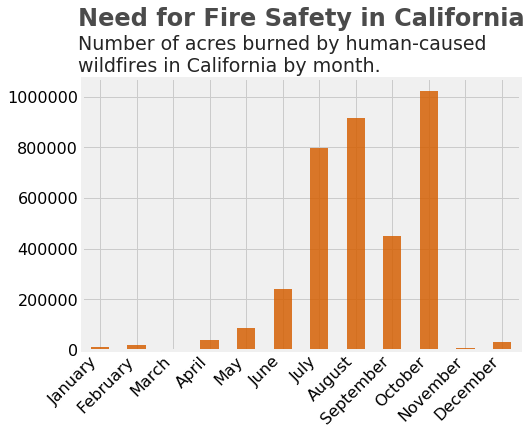

In [56]:
# Aggregate the acres burned by months
acres_per_month = human_fires.groupby('months')['acres_burned'].sum()

# Include March - No wildfires, so report 0
acres_per_month[3] = 0

# Reorder the indices and reindex so that the labeled months are in order
acres_per_month = acres_per_month.reindex(range(1,13))
acres_per_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                         'August', 'September', 'October', 'November', 'December']

fig = plt.figure(figsize = (7, 5))
ax = fig.add_subplot(111)

acres_per_month.plot.bar(ax = ax, color = colors[-2], fontsize = 16)
ax.set_xticklabels(acres_per_month.index, rotation = 45, ha="right")

ax.text(-.6, 1280000, 'Need for Fire Safety in California', fontsize = 24, weight = 'bold', alpha = .7)
ax.text(-.6, 1100000, 'Number of acres burned by human-caused\nwildfires in California by month.', fontsize = 19, alpha = .85)

While there is a noticeable increase in acres burned by wildfires from May to June, special care needs to be taken for wildfire prevention in the months of July through October.

The issue is that [even when measures are already being taken to prepare for wildfires in California](http://cdfdata.fire.ca.gov/incidents/incidents_seasondeclarations?year=2018), devastating wildfires still occur. Obviously, while awareness is important, preventing human-caused wildfires is not simply done by raising awareness, considering wildfire awareness and prevention efforts have always been underway across the United States. 

As Texas was the state with the second largest number of acres burned by human-caused wildfires, let us generate a similar figure.

In [57]:
query = '''
SELECT DISCOVERY_DATE discovery_date, FIRE_SIZE acres_burned FROM Fires
WHERE NOT (
    STAT_CAUSE_DESCR = 'Lightning' 
    OR STAT_CAUSE_DESCR = 'Miscellaneous' 
    OR STAT_CAUSE_DESCR = 'Missing/Undefined')
    AND FIRE_SIZE_CLASS = 'G'
    AND STATE = 'TX'
'''

human_fires = sqlite_helpers.run_query(database, query)
human_fires['discovery_date'] = pd.to_datetime(human_fires['discovery_date'] - epoch, unit='D')
human_fires['months'] = human_fires['discovery_date'].map(lambda x: x.month)

human_fires['months'].value_counts()

4     19
3      9
5      6
2      6
8      5
6      5
1      5
9      3
12     2
11     1
10     1
7      1
Name: months, dtype: int64

Wildfires were reported during all months of the year in Texas. There are no missing months in the Pandas Series.

Text(-0.6,450000,'Number of acres burned by human-caused\nwildfires in Texas by month.')

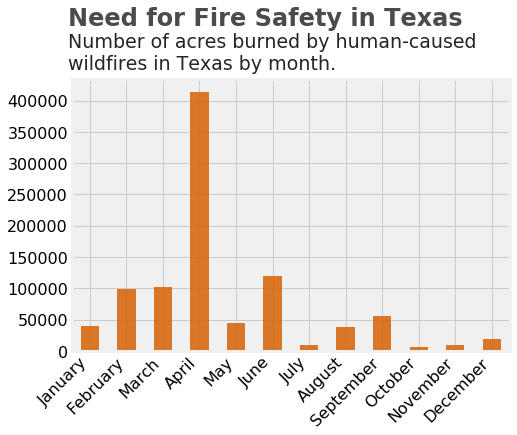

In [62]:
# Aggregate the acres burned by months
acres_per_month = human_fires.groupby('months')['acres_burned'].sum()

# Reorder the indices and reindex so that the labeled months are in order
acres_per_month = acres_per_month.reindex(range(1,13))
acres_per_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                         'August', 'September', 'October', 'November', 'December']

fig = plt.figure(figsize = (7, 5))
ax = fig.add_subplot(111)

acres_per_month.plot.bar(ax = ax, color = colors[-2], fontsize = 16)
ax.set_xticklabels(acres_per_month.index, rotation = 45, ha="right")

ax.text(-.6, 520000, 'Need for Fire Safety in Texas', fontsize = 24, weight = 'bold', alpha = .7)
ax.text(-.6, 450000, 'Number of acres burned by human-caused\nwildfires in Texas by month.', fontsize = 19, alpha = .85)

Judging by this figure, attention needs to be given to wildfire prevention in the first half of the year, particularly from February to June, and especially April.

Given the plethora of wildfire data from 1992 to 2015, we can do similar analyses for each state in the United States. The benefit will allow fire protection agencies to prepare for the worst wildfires in each state, especially in months that have been historically considered to be parts of fire seasons.

However, there is only so much we can do by looking at past wildfires in the dataset, especially if we start noticing anomalies that are linked to rising temperatures. What we have noticed with our database is that there are no records of temperatures in the United States or each state from 1992 to 2015. We can continue our analysis of wildfires by finding and gathering this data.

[Such a dataset exists.](http://berkeleyearth.org/data/) 

In [ ]:
lightning_query = '''
SELECT FIRE_YEAR Year, COUNT(*) Number, SUM(FIRE_SIZE) Acres_Burned FROM Fires
WHERE STAT_CAUSE_DESCR = 'Lightning'
    AND FIRE_SIZE_CLASS = 'G'
GROUP BY Year
'''

human_query = '''
SELECT FIRE_YEAR Year, COUNT(*) Number, SUM(FIRE_SIZE) Acres_Burned FROM Fires
WHERE NOT (
    STAT_CAUSE_DESCR = 'Lightning' 
    OR STAT_CAUSE_DESCR = 'Miscellaneous' 
    OR STAT_CAUSE_DESCR = 'Missing/Undefined')
    AND FIRE_SIZE_CLASS = 'G'
GROUP BY Year
'''

lightning_fires = sqlite_helpers.run_query(database, lightning_query)
human_fires = sqlite_helpers.run_query(database, human_query)

fig = plt.figure(figsize = (14, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

lightning_fires.plot(x = 'Year', y = 'Number', ax = ax1)
lightning_fires.plot(x = 'Year', y = 'Acres_Burned', ax = ax2)
human_fires.plot(x = 'Year', y = 'Number', ax = ax3)
human_fires.plot(x = 'Year', y = 'Acres_Burned', ax = ax4)